## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [6]:
path = Path('/home/user/.fastai/data/CamVid/') # 위에 언급된 github를 clone하여 데이터를 옮겨옴.

In [7]:
path.ls()

[PosixPath('/home/user/.fastai/data/CamVid/val'),
 PosixPath('/home/user/.fastai/data/CamVid/testannot'),
 PosixPath('/home/user/.fastai/data/CamVid/test'),
 PosixPath('/home/user/.fastai/data/CamVid/trainannot'),
 PosixPath('/home/user/.fastai/data/CamVid/val.txt'),
 PosixPath('/home/user/.fastai/data/CamVid/valannot'),
 PosixPath('/home/user/.fastai/data/CamVid/train'),
 PosixPath('/home/user/.fastai/data/CamVid/train.txt'),
 PosixPath('/home/user/.fastai/data/CamVid/test.txt')]

## Data

In [8]:
fnames = get_image_files(path/'val') # val 폴더안에 있는 이미지 목록.
fnames[:3]

[PosixPath('/home/user/.fastai/data/CamVid/val/0016E5_08027.png'),
 PosixPath('/home/user/.fastai/data/CamVid/val/0016E5_07983.png'),
 PosixPath('/home/user/.fastai/data/CamVid/val/0016E5_08113.png')]

In [9]:
lbl_names = get_image_files(path/'valannot') # valannot 폴더안에 있는 이미지 목록. validation annotation의 약자인듯 하다.
lbl_names[:3]

[PosixPath('/home/user/.fastai/data/CamVid/valannot/0016E5_08027.png'),
 PosixPath('/home/user/.fastai/data/CamVid/valannot/0016E5_07983.png'),
 PosixPath('/home/user/.fastai/data/CamVid/valannot/0016E5_08113.png')]

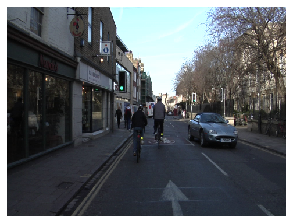

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5)) # 예시 이미지 출력.

In [11]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void']) # 실제 segment 들.

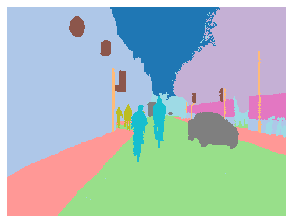

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1) # masking을 한 출력결과 (segmentation 결과)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]),
 tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [14]:
bs = 8 # batch_size = 8

In [15]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

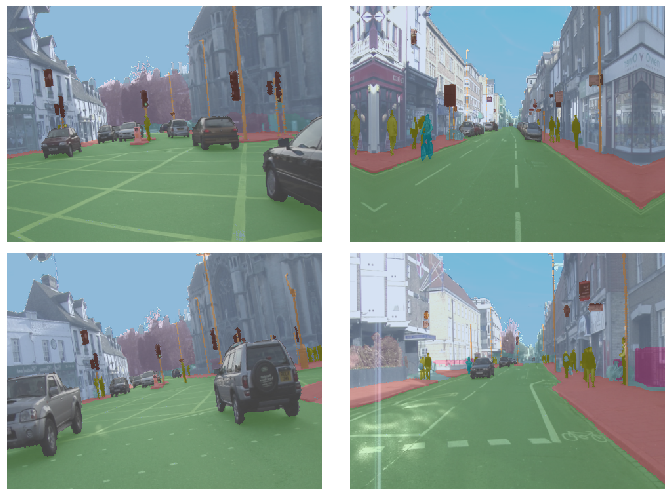

In [17]:
data.show_batch(2, figsize=(10,7))

## Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() # void인 경우를 제외하고 맞춘 class 갯수. accuracy.

In [19]:
metrics=acc_camvid
wd=1e-2

In [20]:
torch.cuda.set_device(1) # local GPU server의 두번째 RTX 2070 Ti에 할당.

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True) # ResNet34를 기본으로 사용한 UNet.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


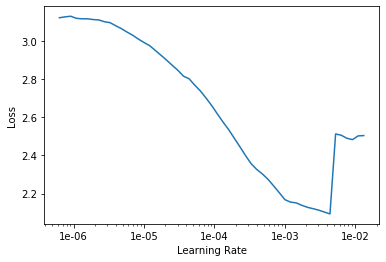

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=2e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) # 10 epoch를 매우 빠른 시간에 끝내버림. 최종 정확도는 무려 0.904

epoch,train_loss,valid_loss,acc_camvid,time
0,1.188273,0.809695,0.772758,00:20
1,0.810764,0.540409,0.854209,00:19
2,0.655730,0.741131,0.799371,00:19
3,0.562772,0.488241,0.864064,00:19
4,0.514209,0.442831,0.874829,00:18
5,0.534979,0.502697,0.874607,00:18
6,0.473840,0.406979,0.890114,00:18
7,0.422361,0.456547,0.874399,00:18
8,0.399454,0.326688,0.905280,00:18
9,0.347641,0.301751,0.904785,00:18


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(lr/100,lr)

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8) # LR을 낮추고 다시 12 epoch를 돌린 결과 0.9330까지 향상.

epoch,train_loss,valid_loss,acc_camvid,time
0,0.299850,0.274473,0.916544,00:20
1,0.286455,0.280138,0.912846,00:19
2,0.282148,0.258886,0.926666,00:19
3,0.281407,0.327812,0.906025,00:19
4,0.281353,0.306451,0.902623,00:19
5,0.277863,0.261323,0.921623,00:19
6,0.295991,0.312083,0.904189,00:19
7,0.293395,0.286177,0.920177,00:19
8,0.286663,0.314756,0.912154,00:19
9,0.275034,0.326458,0.909834,00:19


In [30]:
learn.save('stage-2');

## Go big

In [31]:
learn=None
gc.collect() # release memory

66

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [32]:
size = src_size # 실제 이미지 사이즈. (이전 실험보다 더 크다.)
bs=8

In [33]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [34]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


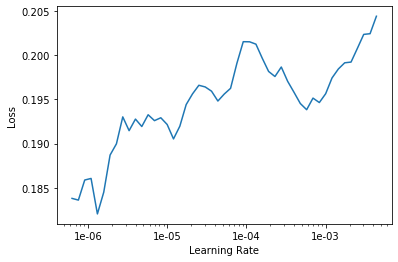

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=1e-3

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) # feature vector가 더 커졌는데도 비슷한 성능을 유지.

epoch,train_loss,valid_loss,acc_camvid,time
0,0.194145,0.233194,0.933140,00:18
1,0.190728,0.237711,0.934342,00:18
2,0.188133,0.228555,0.934811,00:18
3,0.189199,0.227824,0.934979,00:18
4,0.188920,0.272606,0.919972,00:18
5,0.189392,0.242377,0.935465,00:18
6,0.188499,0.267454,0.929431,00:18
7,0.187287,0.219929,0.937582,00:19
8,0.179671,0.235438,0.938687,00:18
9,0.169557,0.227900,0.936834,00:18


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big');

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(lr/1000,lr/10)

In [42]:
learn.fit_one_cycle(10, lrs) # LR을 줄여서 조절했을 땐, 소폭의 향상 (0.005 정도.)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.155212,0.227743,0.938355,00:19
1,0.156316,0.230132,0.938944,00:19
2,0.154519,0.240613,0.936952,00:19
3,0.153279,0.231759,0.938779,00:19
4,0.149724,0.232092,0.939369,00:19
5,0.149158,0.235335,0.938629,00:19
6,0.146897,0.234081,0.939295,00:19
7,0.145569,0.230762,0.939138,00:19
8,0.144106,0.235383,0.938143,00:19
9,0.143763,0.230559,0.939068,00:19


In [43]:
learn.save('stage-2-big')

In [44]:
learn.load('stage-2-big');

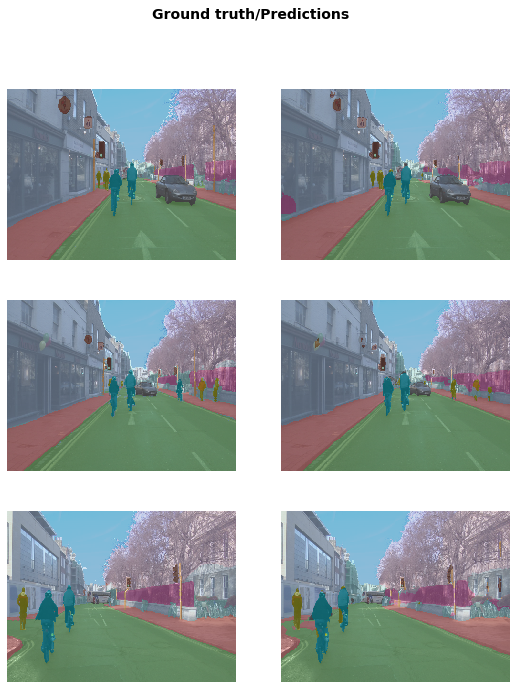

In [45]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [46]:
# start: 480x360

In [47]:
print(learn.summary()) # 최종 Learner에 대한 구조 공개. (DynamicUNet의 결과.)

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________

## Short Comment:

- ResNet34와 UNet으로 다했다.
- 이미지의 해상도가 높으니, 실제 성능에도 영향이 있었다. 하지만 크지 않았다. 이건 왜 일까? 아마도 UNet이 더 많은 feature에 대한 충분하 효율을 내지 못했던 것 같다. (실제로 더 많은 epoch으로 돌려보았으나, 큰 차이는 나지 않았다)
- image segmentation task도 UNet을 통해서 쉽고 빠르게 확인할 수 있었다.

*Epochs많이 돌리는 것 보다 slice 설정이나 model의 layers들을 변경하면 결과에 영향이 더 큰다.* 